# Rolling Sharpe and Beta Calculation: Code + Annotations
##### Written by: Jason Oliner, 10/30/24

#### Part 1: Rolling Sharpe Calculation

In [16]:
#Only run these if necessary! Google Colab will not require installation :D

#!pip install yfinance
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install math

In [2]:
#Import packages in

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [9]:
#Calculate the percent changes of a ticker across a 5yr period

#Typically, there are 252 trading days in a year 
trading_days = 252

#Choose what ticker you're interested in looking at
ticker = yf.Ticker('AAPL')

#Grab the history of said ticker across a period, specifying the metric you want
#Here, we're looking at the Close prices across a 5 year period
stock_prices = ticker.history(period = '5y')['Close']

#Calculate the percentange change of each day, using the percent change formula
stock_returns = stock_prices.pct_change().dropna()

#Changes the index variable to only care about the date (and not the time)
stock_returns.index = stock_returns.index.date

#Look at the resulting data frame
stock_returns

2019-11-04    0.006567
2019-11-05   -0.001437
2019-11-06    0.000428
2019-11-07    0.011541
2019-11-08    0.002737
                ...   
2024-10-25    0.003643
2024-10-28    0.008599
2024-10-29    0.001157
2024-10-30   -0.015278
2024-10-31   -0.018209
Name: Close, Length: 1257, dtype: float64

In [10]:
#Now, we want to assess a risk free rate. To do this, we're going to look at a 5 year treasury bond
#Treasury bonds are a good benchmark since they remain very stable in terms of return (hence "risk-free")

#As before, grab the ticker
benchmark = yf.Ticker('^FVX')

#Then, grab the history (also set to 5 years here).
#NOTE: Make sure this is consistent with your stock. We're looking at the difference of returns so they should have the same amount of data!
five_year_yield = benchmark.history(period = '5y')['Close'] * 0.01    #We multiply by 0.01 here to make it into a decimal (FVX starts off as a percent!)

#Since treasury bonds display "annual" return, we need to change it to a daily return by dividing by the amount of trading days
#We need to do this because individual stocks display daily values, not annual values
risk_free_rate = five_year_yield / (trading_days)

#Then, once again change the index to only look at the date
risk_free_rate.index = risk_free_rate.index.date

#Look at the resulting data frame
risk_free_rate

2019-10-31    0.000060
2019-11-01    0.000062
2019-11-04    0.000064
2019-11-05    0.000066
2019-11-06    0.000065
                ...   
2024-10-25    0.000161
2024-10-28    0.000163
2024-10-29    0.000163
2024-10-30    0.000164
2024-10-31    0.000165
Name: Close, Length: 1259, dtype: float64

In [14]:
#Now to the important part - calculating the excess returns!

#Since you have both returns, simply take the difference to find the excess returns of the stock
excess_returns = stock_returns - risk_free_rate

#Then, take the mean and standard deviation of these excess returns
#NOTE: We look across a rolling period (since it's a "rolling" sharpe), allowing us to better see the return trends over a rolling period of time
rolling_mean = excess_returns.rolling(trading_days).mean()
rolling_std = excess_returns.rolling(trading_days).std()

#Then, calculate the rolling sharpe. And that's it
annualized_rolling_sharpe = math.sqrt(trading_days) * rolling_mean / rolling_std

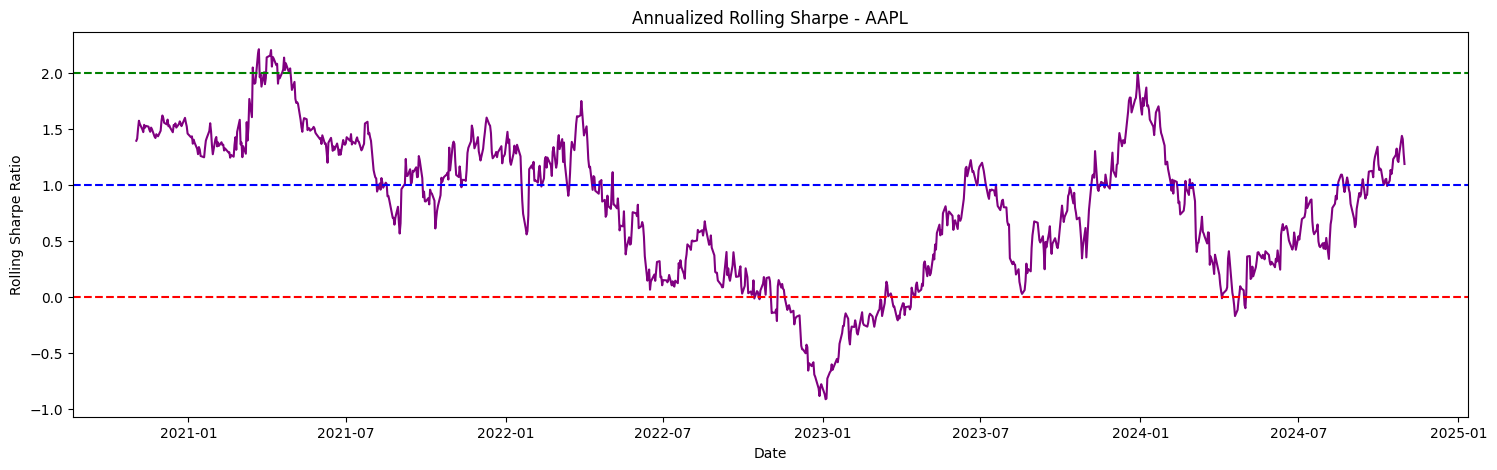

In [12]:
#Now, all we have to do is plot the rolling sharpe (which we just calculated). You can modify this graph however you want :D

plt.figure(figsize=(18, 5))
plt.plot(annualized_rolling_sharpe, color = 'purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=1, color='blue', linestyle='--', linewidth=1.5)
plt.axhline(y=2, color='green', linestyle='--', linewidth=1.5)

plt.title('Annualized Rolling Sharpe - AAPL')
plt.xlabel("Date")
plt.ylabel("Rolling Sharpe Ratio")
plt.show()

#### Part 2: Beta Calculation

In [17]:
#Now, we're going to pivot slightly and look at how to calculate the beta of a stock!
#Remember, beta refers to the sensitivity of a stock compared to the market.

#Start by specifying your start and end dates. Here, I specified a 5yr time frame
start_date = '2019-10-31'
end_date = '2024-10-31'

#Then, specify the tickers you want to calculate the beta of
tickers = ['AAPL', 'MSFT', 'TSLA', 'GOOG', 'GOLD']

#Initialize an empty dictionary (to hold the results)
beta_values = {}

#Now, grab the history of the "market return." In this case, we're just going to use the S&P500 as our metric, but others work perfectly fine!
#This code follows similarly to the code above, where we specify the period and take the percent change
spy = yf.download('^GSPC', start=start_date, end=end_date)
spy['DailyReturn'] = spy['Close'].pct_change()

#Then, iterate through all of the tickers, calculating the beta for each
for stock in tickers:

    #Collect the percent changes of your stock of interest
    stock_data = yf.download(stock, start=start_date, end=end_date)
    stock_data['DailyReturn'] = stock_data['Close'].pct_change()
    
    #Combine the stock data with the market (spy) data
    #This makes a data frame with both values, dropping dates in which there is a mismatch of available data
    returns_df = stock_data[['DailyReturn']].join(spy[['DailyReturn']], lsuffix=f'_{stock}', rsuffix='_SPY').dropna()

    #Calculate the covariance of the returns
    covariance = np.cov(returns_df[f'DailyReturn_{stock}'], returns_df['DailyReturn_SPY'])[0][1]

    #Calculate the variance of the market returns only (following the formula for beta)
    variance = np.var(returns_df['DailyReturn_SPY'])

    #Then, calculate the beta!
    beta = covariance / variance

    #Add said beta to the list, and repeat :D
    beta_values[stock] = beta

#Make a data frame of the beta values...
beta_df = pd.DataFrame(list(beta_values.items()), columns=['Ticker', 'Beta'])

#...and print it!
print(beta_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  Ticker      Beta
0   AAPL  1.184676
1   MSFT  1.173857
2   TSLA  1.553032
3   GOOG  1.125799
4   GOLD  0.446760


Price,DailyReturn_GOLD,DailyReturn_SPY
Ticker,,
Date,,
2019-11-01 00:00:00+00:00,-0.020161,0.009662
2019-11-04 00:00:00+00:00,-0.021752,0.003704
2019-11-05 00:00:00+00:00,-0.006010,-0.001186
2019-11-06 00:00:00+00:00,0.021765,0.000702
2019-11-07 00:00:00+00:00,-0.031953,0.002730
...,...,...
2024-10-24 00:00:00+00:00,-0.023077,0.002146
2024-10-25 00:00:00+00:00,-0.034941,-0.000299


# And that's all folks!
##### As always, please reach out if you have any questions :D